In [15]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time
import random
import scipy
import scipy.stats
import emcee
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import corner

In [2]:
#file with data
file='./transient.npy'
data=np.load(file)

In [3]:
#saved data
t=data[:,0]
flux=data[:,1]
error=data[:,2]

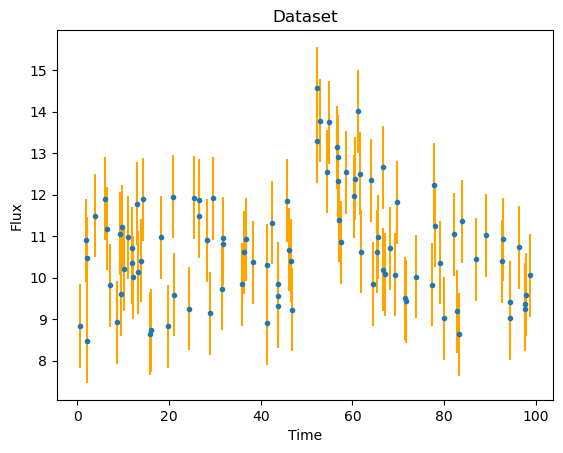

In [51]:
#plot for the dataset
plt.errorbar(t, flux, yerr=error, ecolor='orange', fmt='.')
plt.title('Dataset')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

In [5]:
#model for the data
def model(t1,b1,A1,t01,alpha1):
    m=[]
    for i in range(len(t1)):
        if t1[i]<t01:
            m.append(b1)
        if t1[i]>=t01:
            m.append(b1+A1*np.exp(-alpha1*(t1[i]-t01)))
    return m

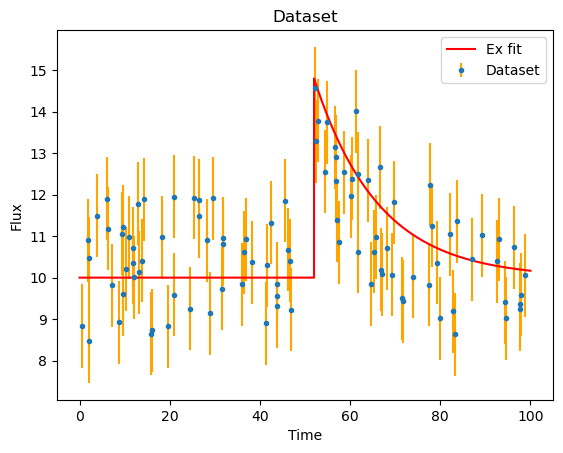

In [52]:
#example of a rough fit
plt.errorbar(t, flux, yerr=error, ecolor='orange', fmt='.',label='Dataset')
plt.plot(np.linspace(0,100,10000), model(np.linspace(0,100,10000), 10, 4.8, 52, 0.07), color='red', label='Ex fit')
plt.title('Dataset')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

In [24]:
def LogLikelihood(u):
    b, A, t0, alpha = u
    mod_y=np.array(model(t,b,A,t0,alpha))
    #gaussian likelihood around the true value of the parameter
    return -0.5*np.sum(((np.array(flux)-mod_y)/error)**2)

#prior of dynesty is in uniform space [0,1]
def Prior(u):
    x1 = u[0] * 50  #linear uniform in [0, 50]
    x2 = u[1] * 50  #linear uniform in [0, 50]
    x3 = u[2] * 100 #linear uniform in [0, 100]
    x4 = 10**(u[3] * 10 - 5)  #log-uniform in [10^-5, 10^5]
    return np.array([x1, x2, x3, x4])

In [8]:
ndim = 4 #number of parameters = number of dimention

sample = dynesty.NestedSampler(LogLikelihood, Prior, ndim, sample='rslice')
sample.run_nested()
results = sample.results

8039it [01:25, 94.43it/s, +500 | bound: 37 | nc: 1 | ncall: 268502 | eff(%):  3.186 | loglstar:   -inf < -48.753 <    inf | logz: -64.041 +/-  0.172 | dlogz:  0.001 >  0.509]


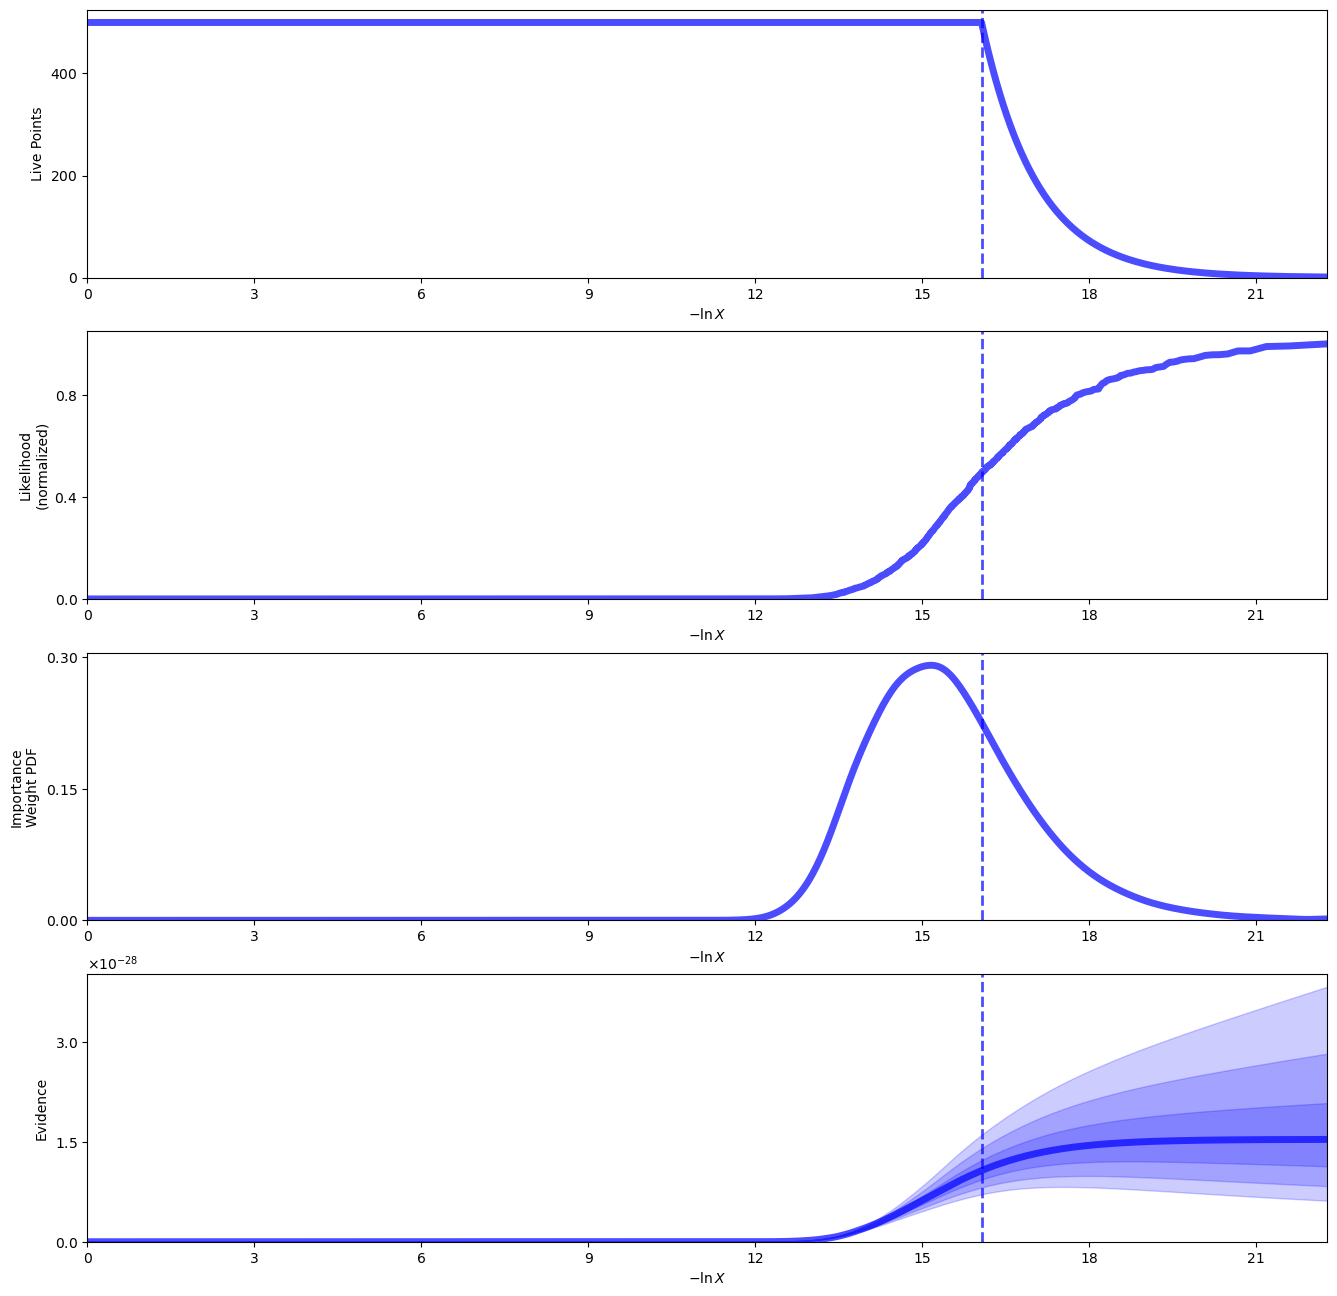

In [9]:
#Plot a summary of the run
fig_results, axes_results = dyplot.runplot(results)

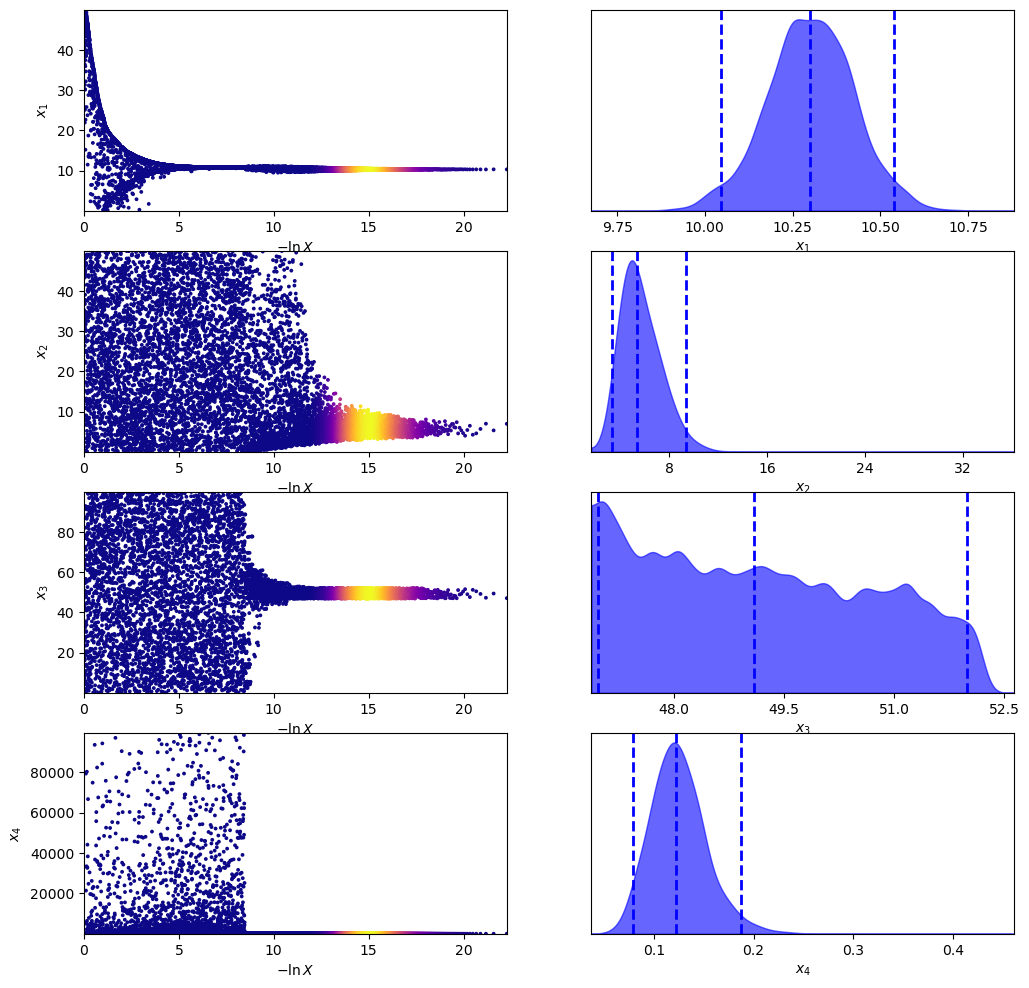

In [10]:
#traceplot of the result
fig_trace, axes_trace = dyplot.traceplot(results)

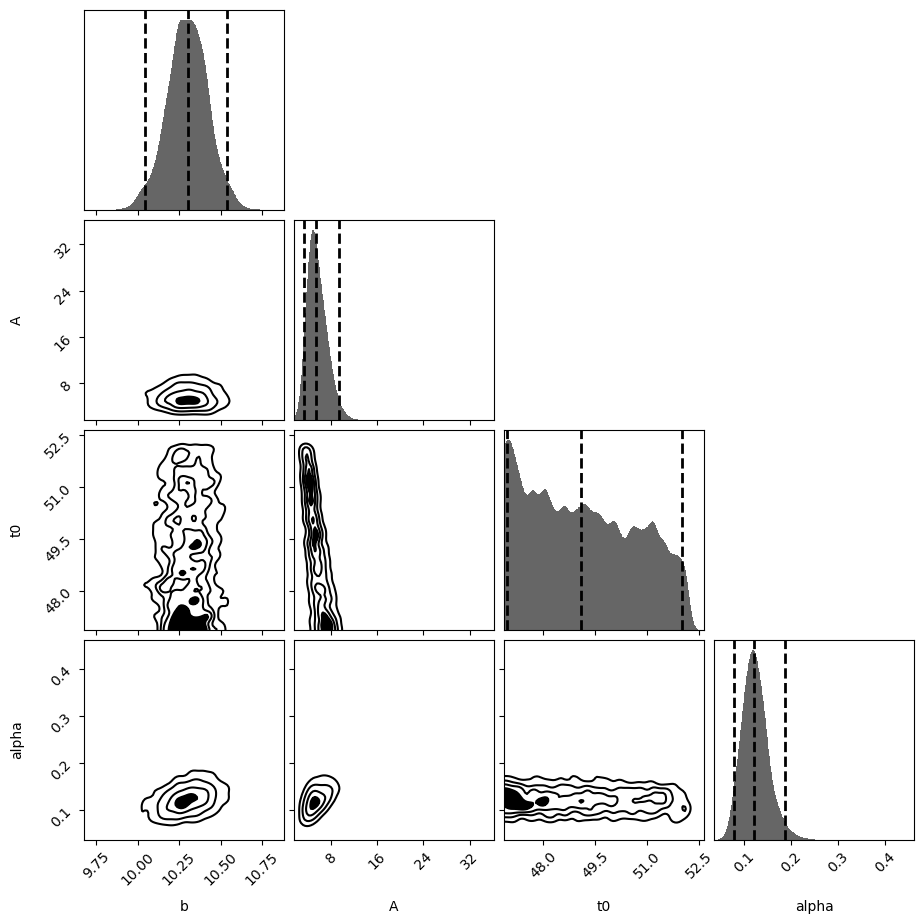

In [11]:
#corner plot not in normalized weights
fig_corner, axes_corner = dyplot.cornerplot(results, labels=['b', 'A', 't0', 'alpha'])

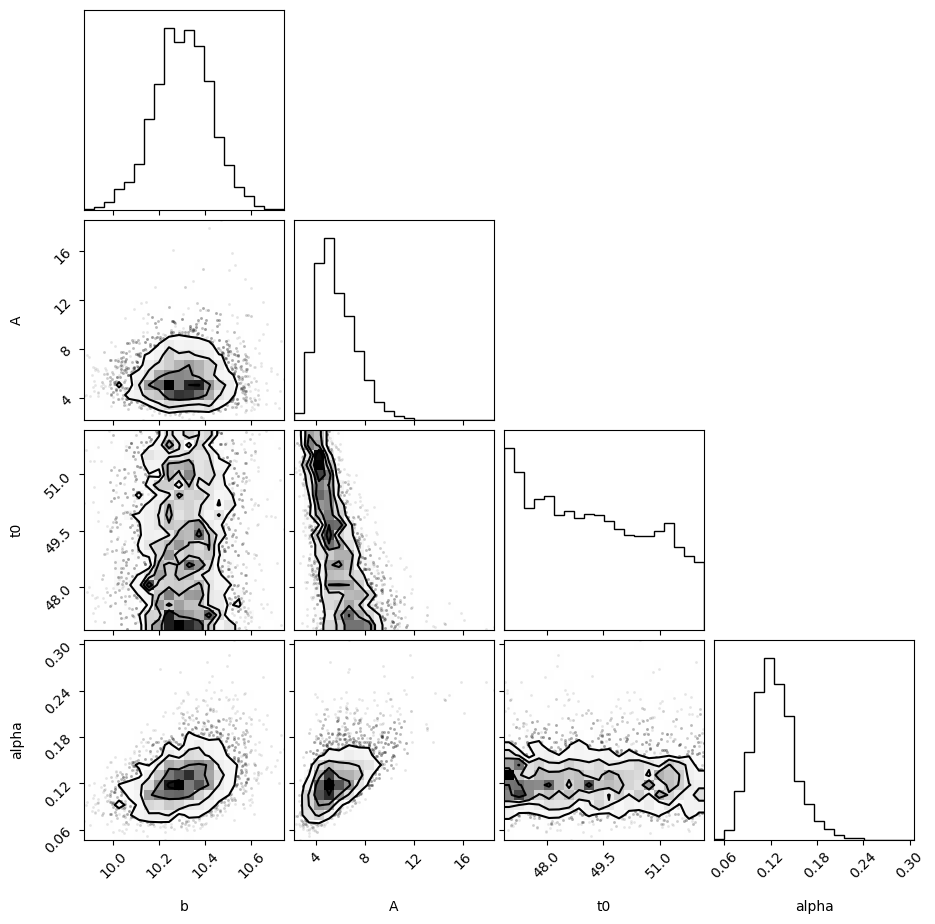

In [17]:
#corner plot with same weights
weights = np.exp(results.logwt - results.logz[-1])
samples_equal = dyfunc.resample_equal(results.samples, weights)
corner.corner(samples_equal, labels=['b', 'A', 't0', 'alpha'])
plt.show()

In [21]:
#medain and error of the parameters
labels=['b', 'A', 't0', 'alpha']
quantiles = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights) for samps in results.samples.T]

for q,l in zip(quantiles,labels):
    low,med,up=q
    print(l+"   "+str(med)+" +"+str(up-med)+" -"+str(med-low))

b   10.300497530901982 +0.20006611063434399 -0.20169503632957664
A   5.3727521114617405 +3.2582740375954353 -1.812752248177175
t0   49.09056486260605 +2.6984028322126363 -2.0611743183597184
alpha   0.12217042081853466 +0.0520135596865611 -0.03889741839240582


In [22]:
results.summary()

Summary
nlive: 500
niter: 8039
ncall: 268002
eff(%):  3.186
logz: -64.041 +/-  0.305


In [27]:
#second possible model for the data
def model_2(t1,b1,A1,t01,sigma1):
    return (b1+A1*np.exp(-(t1-t01)**2/(2*sigma1**2)))

In [28]:
#likelihood and prior for the 2 model
def LogLikelihood_2(u):
    b, A, t0, sigma = u
    mod_y=np.array(model_2(t,b,A,t0,sigma))
    #gaussian likelihood around the true value of the parameter
    return -0.5*np.sum(((np.array(flux)-mod_y)/error)**2)

#prior of dynesty is in uniform space [0,1]
def Prior_2(u):
    x1 = u[0] * 50  #linear uniform in [0, 50]
    x2 = u[1] * 50  #linear uniform in [0, 50]
    x3 = u[2] * 100 #linear uniform in [0, 100]
    x4 = 10**(u[3] * 4 - 2) #2)  #log-uniform in [10^-2, 10^2]
    return np.array([x1, x2, x3, x4])

In [29]:
#second possible model
sample_2 = dynesty.NestedSampler(LogLikelihood_2, Prior_2, ndim, sample='rslice')
sample_2.run_nested()
results_2 = sample_2.results

8379it [00:31, 261.87it/s, +500 | bound: 39 | nc: 1 | ncall: 283387 | eff(%):  3.139 | loglstar:   -inf < -52.416 <    inf | logz: -68.444 +/-  0.179 | dlogz:  0.001 >  0.509]


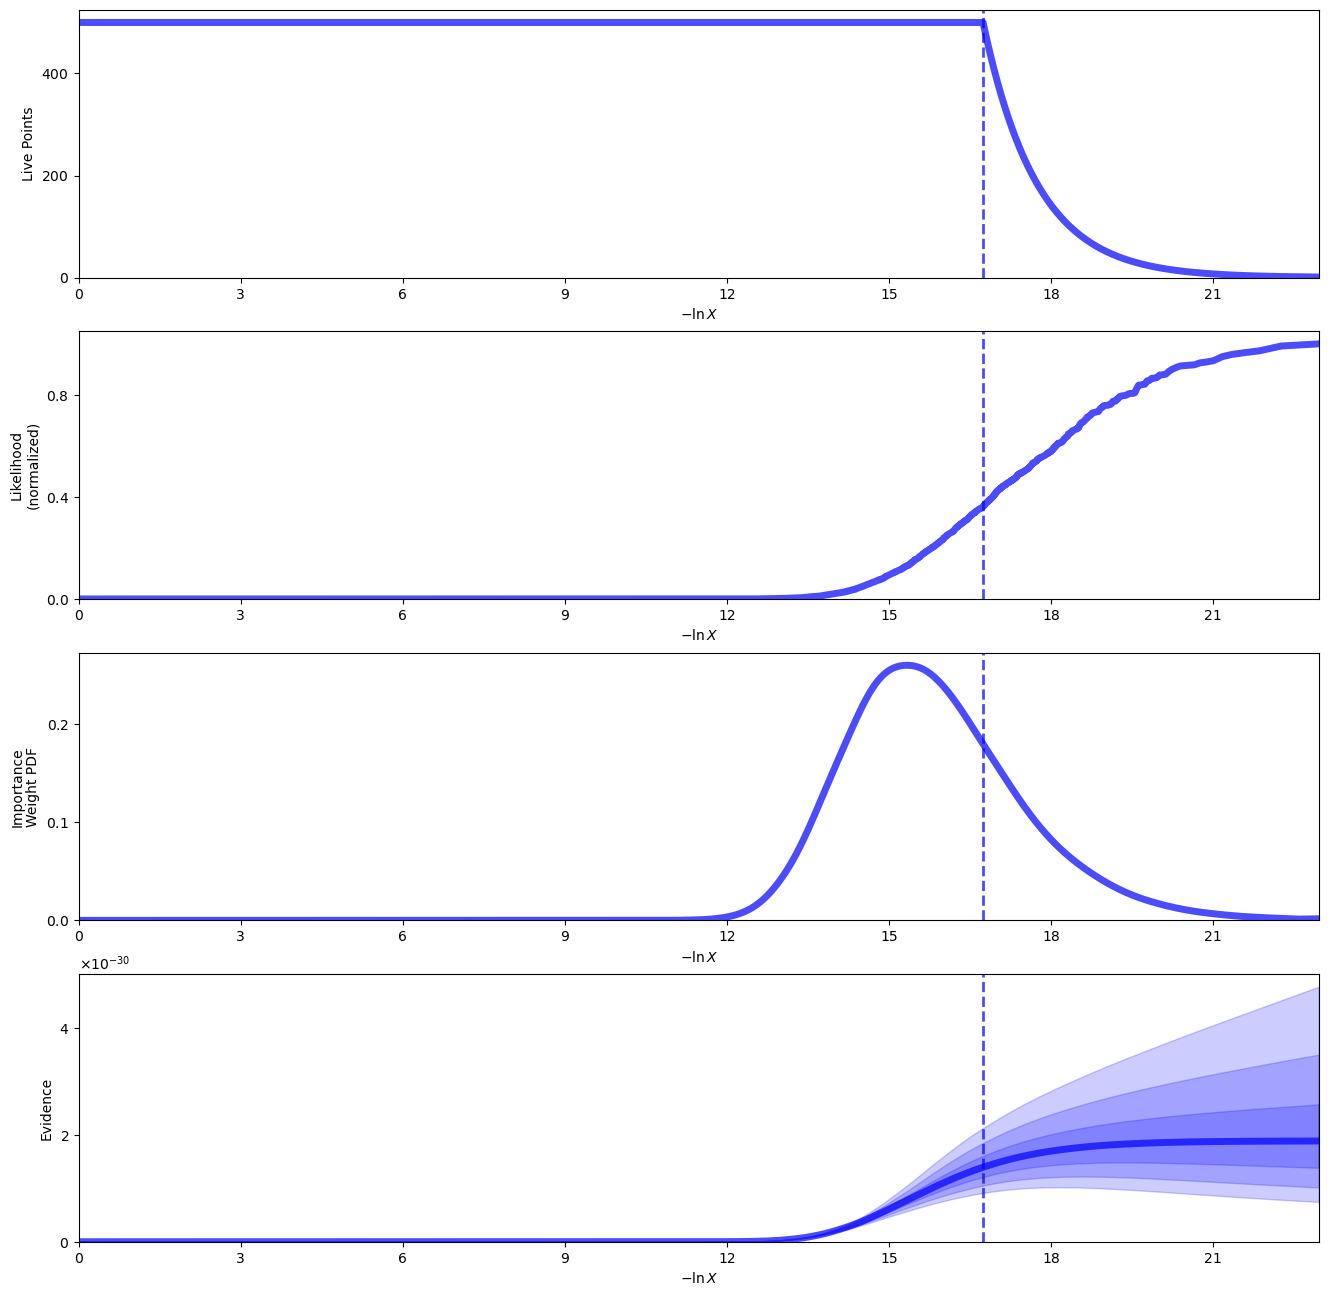

In [30]:
#Plot a summary of the run
fig_results_2, axes_results_2 = dyplot.runplot(results_2)

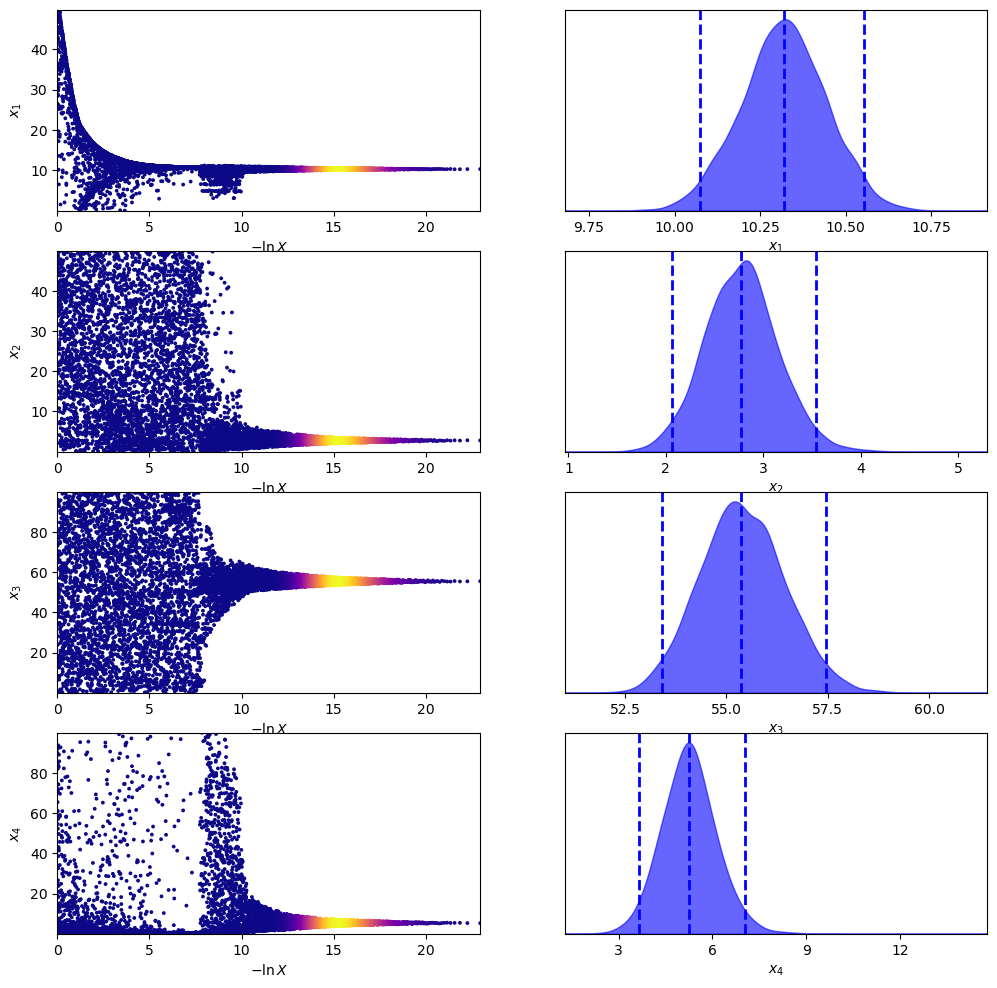

In [31]:
#traceplot of the result
fig_trace_2, axes_trace_2 = dyplot.traceplot(results_2)

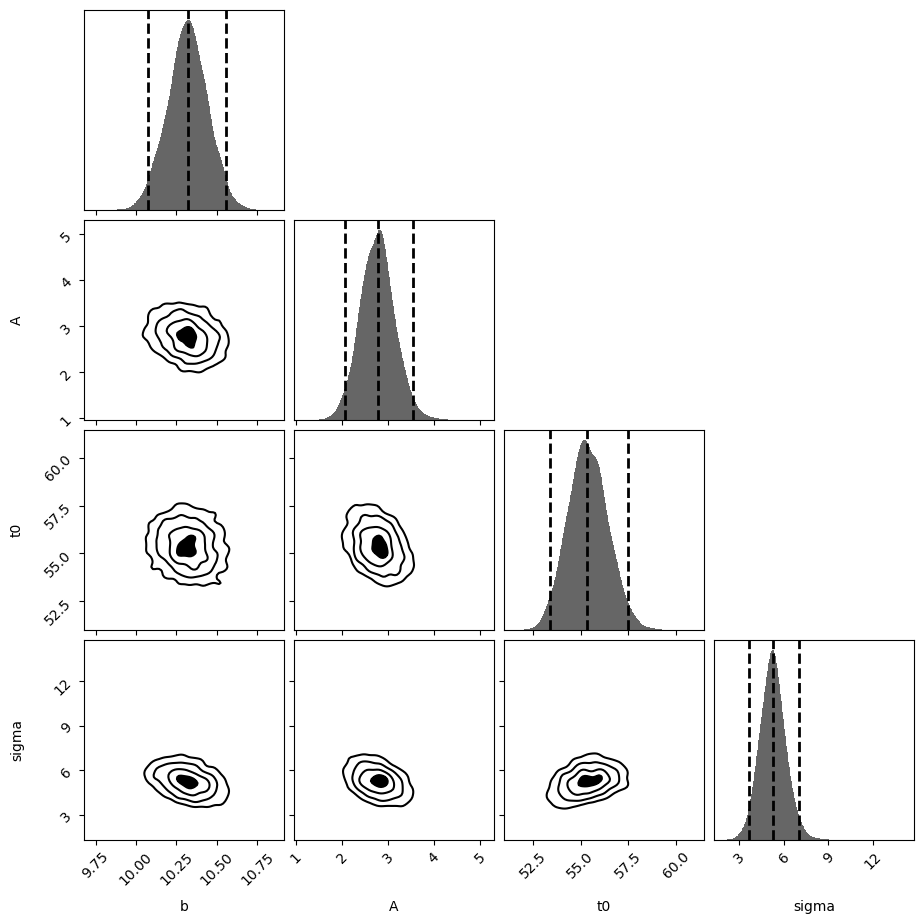

In [32]:
#corner plot not in normalized weights
fig_corner_2, axes_corner_2 = dyplot.cornerplot(results_2, labels=['b', 'A', 't0', 'sigma'])

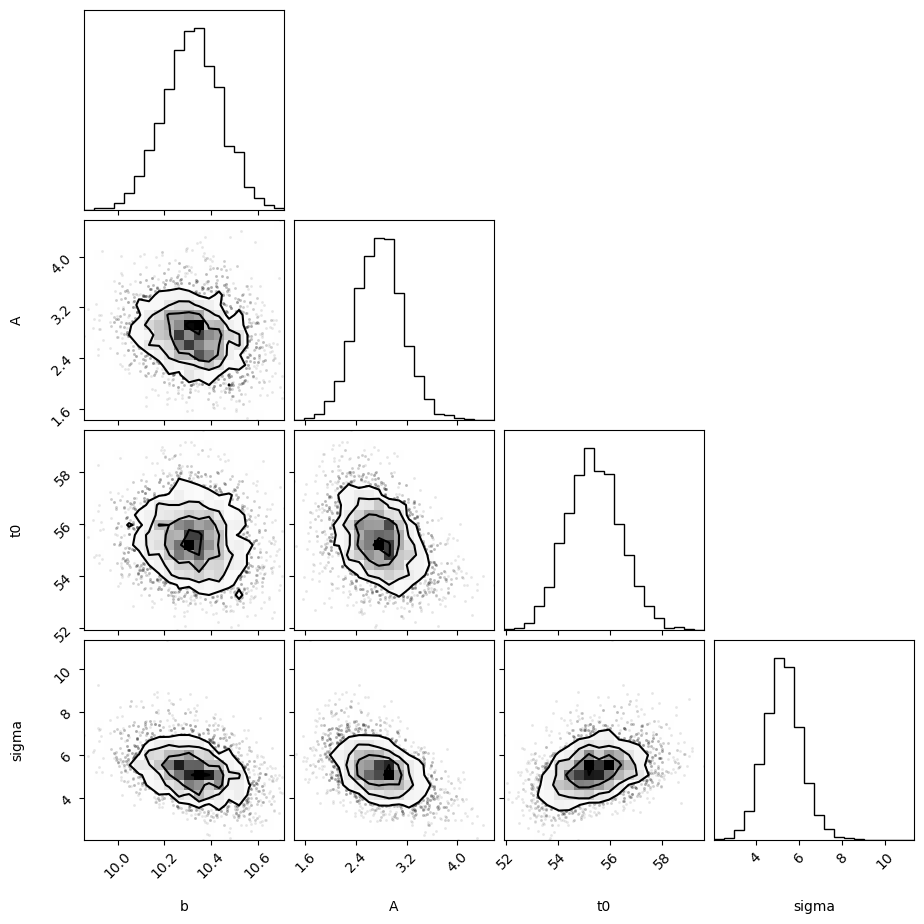

In [34]:
#corner plot with same weights
weights_2 = np.exp(results_2.logwt - results_2.logz[-1])
samples_equal_2 = dyfunc.resample_equal(results_2.samples, weights_2)
corner.corner(samples_equal_2, labels=['b', 'A', 't0', 'sigma'])
plt.show()

In [43]:
#medain and error of the parameters
labels=['b', 'A', 't0', 'sigma']
quantiles = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights_2) for samps in results_2.samples.T]
params_2=[]

for q,l in zip(quantiles,labels):
    low,med,up=q
    print(l+"   "+str(med)+" +"+str(up-med)+" -"+str(med-low))
    params_2.append(med)

b   10.32005234177476 +0.20303375116498934 -0.20733789207714715
A   2.7764077218960534 +0.6187470309690353 -0.6143555311794411
t0   55.361246233642 +1.7437970086775394 -1.6364203876908547
sigma   5.243902359752763 +1.4580206825732356 -1.349122165477222


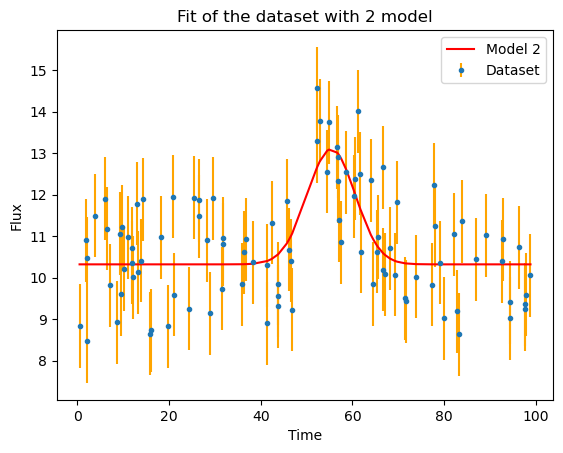

In [50]:
#example of fit for 2 model
plt.errorbar(t, flux, yerr=error, ecolor='orange', fmt='.', label='Dataset')
plt.plot(t, model_2(t,params_2[0], params_2[1], params_2[2], params_2[3]), color='red', label='Model 2')
plt.title('Fit of the dataset with 2 model')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

In [35]:
results_2.summary()

Summary
nlive: 500
niter: 8379
ncall: 282887
eff(%):  3.139
logz: -68.444 +/-  0.310


In [42]:
#ratio between the two logz
print(np.exp(results.logz[-1])/np.exp(results_2.logz[-1])) #the result in log space
#the best model is the exp cut

81.68553416827798
